In [39]:
# %pip install stability-sdk
# %pip install Flask Werkzeug --upgrade

In [27]:
import getpass, os

# NB: host url is not prepended with \"https\" nor does it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# To get your API key, visit https://beta.dreamstudio.ai/membership
os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

Enter your API Key········


In [29]:
import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], 
    verbose=True,
)

In [38]:
import os
from flask import Flask, request, redirect, url_for
from werkzeug.utils import secure_filename
from flask import send_from_directory
from PIL import Image
UPLOAD_FOLDER = './test'
ALLOWED_EXTENSIONS = set(['pdf', 'png', 'jpg', 'jpeg', 'gif'])

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024
def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1] in ALLOWED_EXTENSIONS

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        file = request.files['file']
        thought = request.form.get('thought')
        if file and allowed_file(file.filename):
            image = Image.open(file)
            answers = stability_api.generate(
                prompt = thought,
                init_image=image.resize((256,256)),
                seed=12345, # if provided, specifying a random seed makes results deterministic
                steps=30, # defaults to 30 if not specified
                start_schedule=0.6,
            )
            for resp in answers:
                for artifact in resp.artifacts:
                    if artifact.finish_reason == generation.FILTER:
                        warnings.warn(
                            "Your request activated the API's safety filters and could not be processed."
                            "Please modify the prompt and try again.")
                    if artifact.type == generation.ARTIFACT_IMAGE:
                        img = Image.open(io.BytesIO(artifact.binary))
            rgb_im = img.convert("RGB")
            rgb_im.save("./test/test.jpg")
            filename = "test.jpg"
            return redirect(url_for('uploaded_file',filename=filename))
    return '''
    <!doctype html>
    <title>Upload new File and your thought</title>
    <h1>Upload new File </h1>
    <form action="" method=post enctype=multipart/form-data>
      <p><input type=file name=file>
         <input name=thought type=text>
         <input type=submit value=Upload>
    </form>
    '''

@app.route('/uploads/<filename>')
def uploaded_file(filename):
    return send_from_directory(app.config['UPLOAD_FOLDER'],
                               filename)
if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.123:5000
Press CTRL+C to quit
127.0.0.1 - - [10/Mar/2023 10:27:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Mar/2023 10:27:21] "POST / HTTP/1.1" 302 -
127.0.0.1 - - [10/Mar/2023 10:27:21] "GET /uploads/test.jpg HTTP/1.1" 200 -


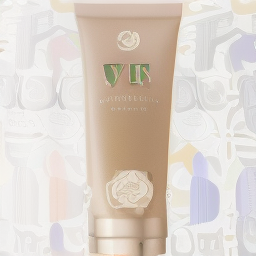

In [11]:
# the object returned is a python generator
from PIL import Image
image = Image.open('C:\\Users\\88697\\Desktop\\照片\\寶貝\\想買的化妝品_201122_9.jpg')
answers = stability_api.generate(
    prompt="a lotion in the middle ,in front of rose in the background",
    init_image=image.resize((256,256)),
    seed=12345, # if provided, specifying a random seed makes results deterministic
    steps=30, # defaults to 30 if not specified
    start_schedule=0.6,
)
# C:\Users\88697\Desktop\照片\寶貝\想買的化妝品_201122_9.jpg
# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)